In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys; sys.path.append("/Users/zhiyuanyao/Projects/handful-of-trials")
import seaborn as sns
import tensorflow as tf

/Users/zhiyuanyao/miniconda3/envs/tf1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/zhiyuanyao/miniconda3/envs/tf1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/zhiyuanyao/miniconda3/envs/tf1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/zhiyuanyao/miniconda3/envs/tf1

In [3]:
from BNN import BNN
from dotmap import DotMap
from dmbrl.modeling.layers import FC

# create dataset

In [4]:
f1 = lambda x: np.sqrt(1-x**2)
f2 = lambda x: -np.sqrt(1-x**2)
def clip(x,lower, upper):
    if x < upper:
        if x > lower:
            return x
        else:
            return lower
    else:
        return upper

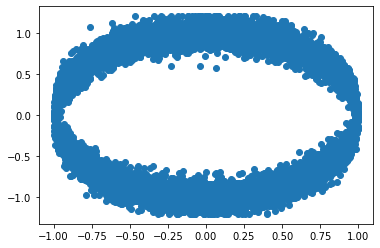

In [5]:
x_ls = np.random.uniform(-1, 1, size = 10000)
data = [(x, clip((f1(x) if np.random.uniform()<0.5 else f2(x))+
         np.random.normal(scale=0.1), -1.2, 1.2)) for x in x_ls]

data_control = [(x, clip((f1(x) if np.random.uniform()<0.5 else f1(x))+
         np.random.normal(scale=0.1), -1.2, 1.2)) for x in x_ls]
plt.scatter(*zip(*data))

In [6]:
x_range = 0.5
selected = [item[1] for item in data if x_range-0.01 < item[0] < x_range+0.01 ]

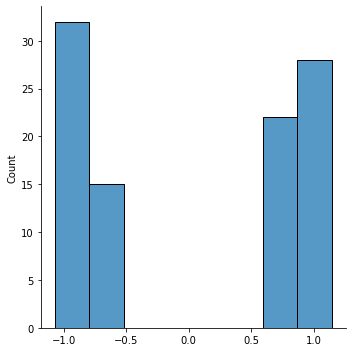

In [7]:
sns.displot(selected)

In [8]:
def nn_constructor(param, model_in, model_out):
    model = BNN(param)
    if not param.load_model:
        model.add(FC(16, input_dim=model_in, activation="swish", weight_decay=0.000025))
        model.add(FC(16, activation="swish", weight_decay=0.000075))
        model.add(FC(model_out, weight_decay=0.0001))
    model.finalize(tf.train.AdamOptimizer, {"learning_rate": 0.001})
    return model

In [9]:
config = DotMap(name = "BNN", 
                model_dir = "models", 
                sess = None, 
                load_model = False, 
                num_networks = 3
                )

config_control = DotMap(name = "BNN_control", 
                model_dir = "models", 
                sess = None, 
                load_model = False, 
                num_networks = 3
                )

model = nn_constructor(config, 1, 1)
model_control = nn_constructor(config_control, 1, 1)



Created an ensemble of 3 neural networks with variance predictions.



Created an ensemble of 3 neural networks with variance predictions.


In [10]:
X, y = list(zip(*data))
X = np.array(X).reshape(-1, 1)
y = np.array(y).reshape(-1, 1)

In [11]:
model.train(X, y)

Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.


Network training: 100%|██████████| 100/100 [02:32<00:00,  1.53s/epoch(s), Training loss(es)=[0.6762904 0.69015   0.6816084]]  


In [12]:
X_control, y_control = list(zip(*data_control))
X_control = np.array(X_control).reshape(-1, 1)
y_control = np.array(y_control).reshape(-1, 1)

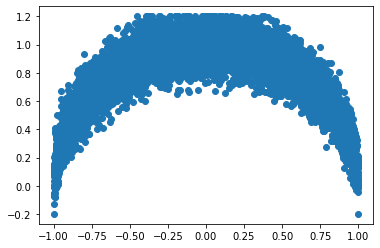

In [13]:
plt.scatter(X_control, y_control)

In [14]:
model_control.train(X_control, y_control)

Network training: 100%|██████████| 100/100 [03:33<00:00,  2.13s/epoch(s), Training loss(es)=[0.01021336 0.01024883 0.01025242]]


In [15]:
res_control = model_control.predict(np.array([[0], [-1], [1], [0.5], [-0.5]]), factored = True)

In [16]:
res = model.predict(np.array([[0], [-1], [1], [0.5], [-0.5]]), factored = True)

res

[array([[[-0.0195186 ],
         [ 0.00430005],
         [-0.01547475],
         [-0.01582873],
         [-0.01547976]],
 
        [[-0.01368746],
         [ 0.05014885],
         [ 0.01466596],
         [-0.0206842 ],
         [-0.0176852 ]],
 
        [[ 0.01224419],
         [-0.00274459],
         [-0.02149294],
         [ 0.00691296],
         [ 0.00845396]]], dtype=float32),
 array([[[0.9239979 ],
         [0.06584913],
         [0.0628683 ],
         [0.8104024 ],
         [0.83110136]],
 
        [[0.9249593 ],
         [0.06364962],
         [0.07321391],
         [0.82388806],
         [0.81358993]],
 
        [[0.93279123],
         [0.06660739],
         [0.07196903],
         [0.821625  ],
         [0.83363974]]], dtype=float32)]

In [39]:
len(res)

2

In [47]:
np.round(res_control[1], 2)

array([[[0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01]],

       [[0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01]],

       [[0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01]]], dtype=float32)

In [44]:
np.round(res[1], 2)

array([[[0.92],
        [0.06],
        [0.07],
        [0.82],
        [0.81]],

       [[0.92],
        [0.06],
        [0.07],
        [0.82],
        [0.81]],

       [[0.92],
        [0.07],
        [0.07],
        [0.82],
        [0.82]]], dtype=float32)

In [49]:
plt.plot(model.predict(np.arange(-1, 1, 0.01).reshape(-1, 1), factored = True)[0][0])
plt.plot(model.predict(np.arange(-1, 1, 0.01).reshape(-1, 1), factored = True)[0][1])
plt.plot(model.predict(np.arange(-1, 1, 0.01).reshape(-1, 1), factored = True)[0][2])

Error: Canceled future for execute_request message before replies were done

In [17]:
model.predict(np.arange(-1, 1, 0.01).reshape(-1, 1), factored = True)

Error: Canceled future for execute_request message before replies were done

In [ ]:
np.arange(-1, 1, 0.01).reshape(-1, 1)